#Deep Learning - Homework 1
# Multi-Layer Perceptron - Regression

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([2615, 1])) that is different to the input size (torch.Size([2615])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1122, 1])) that is different to the input size (torch.Size([1122])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/50, Train MSE: 0.099744, Test MSE: 0.077415
Epoch 2/50, Train MSE: 0.068087, Test MSE: 0.067252
Epoch 3/50, Train MSE: 0.057575, Test MSE: 0.064647
Epoch 4/50, Train MSE: 0.054698, Test MSE: 0.064019
Epoch 5/50, Train MSE: 0.053912, Test MSE: 0.063852
Epoch 6/50, Train MSE: 0.053665, Test MSE: 0.063775
Epoch 7/50, Train MSE: 0.053552, Test MSE: 0.063708
Epoch 8/50, Train MSE: 0.053472, Test MSE: 0.063638
Epoch 9/50, Train MSE: 0.053400, Test MSE: 0.063565
Epoch 10/50, Train MSE: 0.053332, Test MSE: 0.063490
Epoch 11/50, Train MSE: 0.053264, Test MSE: 0.063415
Epoch 12/50, Train MSE: 0.053198, Test MSE: 0.063341
Epoch 13/50, Train MSE: 0.053132, Test MSE: 0.063267
Epoch 14/50, Train MSE: 0.053068, Test MSE: 0.063193
Epoch 15/50, Train MSE: 0.053004, Test MSE: 0.063122
Epoch 16/50, Train MSE: 0.052942, Test MSE: 0.063051
Epoch 17/50, Train MSE: 0.052881, Test MSE: 0.062981
Epoch 18/50, Train MSE: 0.052821, Test MSE: 0.062913
Epoch 19/50, Train MSE: 0.052763, Test MSE: 0.062846
Ep

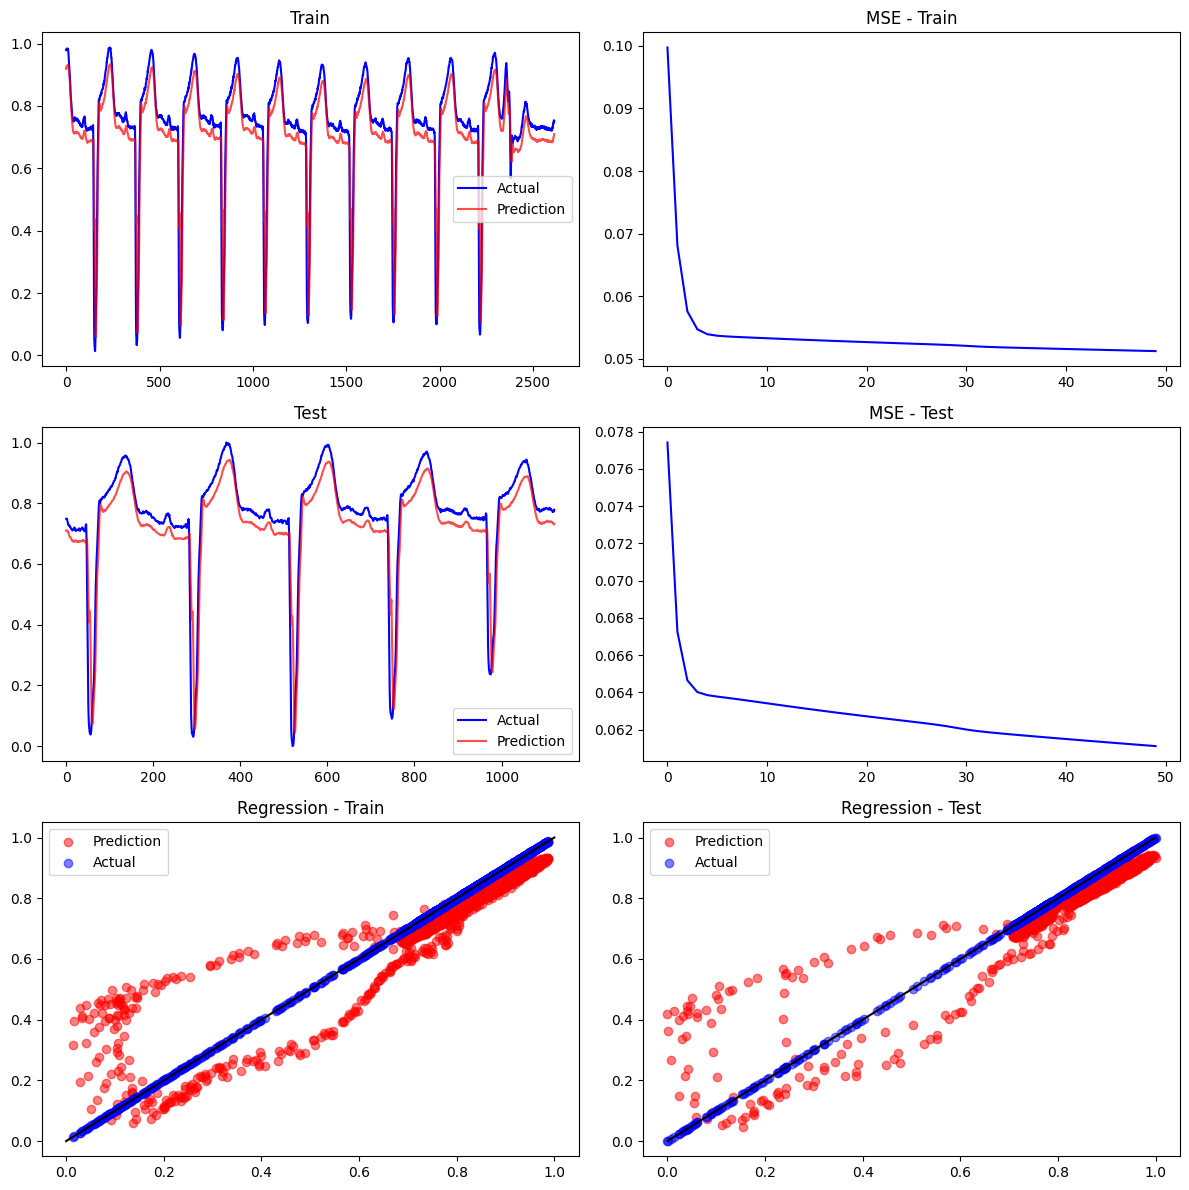

Final Train MSE: = 0.051210
Final Test MSE = 0.061117


In [14]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


# load data
file_path = "/content/ECG.xlsx"
df = pd.read_excel(file_path)
# initialize weight
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.uniform_(m.weight, a=-0.5, b=0.5)
        torch.nn.init.zeros_(m.bias)
        m.bias.requires_grad = False
# normalize
data = df.values.astype(float)
scaler = MinMaxScaler()
data = scaler.fit_transform(data)


# ------------------------------------------------------------------------------
# sequence
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10
X, y = create_sequences(data, seq_length)

# ------------------------------------------------------------------------------
# Split Data
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
# تبدیل به تنسور
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# ------------------------- ----------------------------------------------------
# model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.fc4 = nn.Linear(hidden_sizes[2], output_size)
        self.activation = nn.LeakyReLU(0.01)

    def forward(self, x):
        x = x.view(x.shape[0], -1)  # [batch_size, seq_length]
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.fc4(x)
        return x

# ------------------------------------------------------------------------------
# create
input_size = seq_length
hidden_sizes = [64, 32, 16]
output_size = 1

model = MLP(input_size, hidden_sizes, output_size)
model.apply(init_weights)
criterion = nn.MSELoss()

optimizer = optim.SGD([
    {'params': model.fc1.parameters(), 'lr': 0.05},
    {'params': model.fc2.parameters(), 'lr': 0.01},
    {'params': model.fc3.parameters(), 'lr': 0.01},
    {'params': model.fc4.parameters(), 'lr': 0.01}
])

# ------------------------------------------------------------------------------
# train
epochs = 50
mse_train, mse_test = [], []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    y_pred_train = model(X_train_tensor).squeeze()
    loss_train = criterion(y_pred_train, y_train_tensor)
    loss_train.backward()
    optimizer.step()

    # test
    model.eval()
    with torch.no_grad():
        y_pred_test = model(X_test_tensor).squeeze()
        loss_test = criterion(y_pred_test, y_test_tensor)

    mse_train.append(loss_train.item())
    mse_test.append(loss_test.item())

    print(f"Epoch {epoch+1}/{epochs}, Train MSE: {loss_train.item():.6f}, Test MSE: {loss_test.item():.6f}")

# ------------------------------------------------------------------------------
# plot
y_pred_train_np = y_pred_train.detach().numpy()
y_pred_test_np = y_pred_test.detach().numpy()
y_train_np = y_train_tensor.numpy()
y_test_np = y_test_tensor.numpy()

fig, axs = plt.subplots(3, 2, figsize=(12, 12))

# 1. نمودار داده‌های واقعی و پیش‌بینی برای داده‌های آموزش
axs[0, 0].plot(y_train_np, label="Actual", color='blue')
axs[0, 0].plot(y_pred_train_np, label="Prediction", color='red', alpha=0.7)
axs[0, 0].set_title("Train")
axs[0, 0].legend()

# 2. نمودار MSE در طول دوره‌های آموزش
axs[0, 1].plot(mse_train, label="MSE Train", color='blue')
axs[0, 1].set_title("MSE - Train")

# 3. نمودار داده‌های واقعی و پیش‌بینی برای داده‌های تست
axs[1, 0].plot(y_test_np, label="Actual", color='blue')
axs[1, 0].plot(y_pred_test_np, label="Prediction", color='red', alpha=0.7)
axs[1, 0].set_title("Test")
axs[1, 0].legend()

# 4. نمودار MSE در طول دوره‌های تست
axs[1, 1].plot(mse_test, label="MSE Test", color='blue')
axs[1, 1].set_title("MSE - Test")

# 5. نمودار رگرسیون - آموزش
axs[2, 0].scatter(y_train_np, y_pred_train_np, color='red', alpha=0.5, label="Prediction")
axs[2, 0].scatter(y_train_np, y_train_np, color='blue', alpha=0.5, label="Actual")
axs[2, 0].plot([0, 1], [0, 1], color='black')  # خط ایده‌آل
axs[2, 0].set_title("Regression - Train")
axs[2, 0].legend()

# 6. نمودار رگرسیون - تست
axs[2, 1].scatter(y_test_np, y_pred_test_np, color='red', alpha=0.5, label="Prediction")
axs[2, 1].scatter(y_test_np, y_test_np, color='blue', alpha=0.5, label="Actual")
axs[2, 1].plot([0, 1], [0, 1], color='black')  # خط ایده‌آل
axs[2, 1].set_title("Regression - Test")
axs[2, 1].legend()

plt.tight_layout()
plt.show()

print(f"Final Train MSE: = {mse_train[-1]:.6f}")
print(f"Final Test MSE = {mse_test[-1]:.6f}")
